<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/R/03_ARMA_forecasting_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARMA (p, q)

Colab에서 아래 네 가지 경우엔 !pip install -U rpy2와 %load_ext rpy2.ipython 없이도 R이 됩니다.

런타임 자체가 R일 때
Colab에서 Runtime → Change runtime type → Language: R로 바꾸면, 노트북 커널이 IRkernel(R) 로 바뀌어 모든 셀을 R로 실행합니다. 이땐 %%R 매직도 필요 없고, rpy2도 쓰지 않습니다. (오히려 저 두 줄을 쓰면 오류가 날 수 있어요.)

노트북 메타데이터가 R 커널로 저장된 경우
.ipynb의 커널 메타가 R이면 Colab이 자동으로 R 런타임을 잡아줍니다. 이때도 rpy2 불필요.

세션에 rpy2가 이미 설치·로드돼 있는 경우
같은 런타임 세션에서 이전 셀/노트북이 이미
!pip install rpy2 + %load_ext rpy2.ipython 을 실행해 둔 상태라면, 다시 호출할 필요가 없습니다. (%%R 매직이 바로 동작)

Colab에서 R을 안정적으로 쓰는 최소 템플릿

In [ ]:
# 파이썬 커널에서만 실행하세요
try:
    import rpy2
except ImportError:
    !pip -q install -U rpy2

# 이미 로드된 경우 에러 없이 넘어갑니다.
try:
    %load_ext rpy2.ipython
except:
    pass

# 1) 준비 & 패키지

In [9]:
#%%R
# ---- 패키지 설치/로드 ----
if (!requireNamespace("pacman", quietly = TRUE)) install.packages("pacman", quiet = TRUE)
pacman::p_load(quantmod, forecast, ggplot2, dplyr, tidyr, scales, zoo)

options(repr.plot.width = 12, repr.plot.height = 5)  # Jupyter(IRkernel)/Colab R plotting size
theme_set(theme_minimal(base_size = 12))

# 일부 경고는 의도적으로 억제 (수렴/비가역 등)
options(warn = 1)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘xts’, ‘zoo’, ‘TTR’

trying URL 'https://cran.rstudio.com/src/contrib/xts_0.14.1.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/zoo_1.8-14.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/TTR_0.24.4.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/quantmod_0.4.28.tar.gz'

The downloaded source packages are in
	‘/tmp/RtmpAWrc1b/downloaded_packages’

quantmod installed
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘quadprog’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘RcppArmadillo’

trying URL 'https://cran.rstudio.com/src/contrib/quadprog_1.5-8.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/colorspace_2.1-2.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/fracdiff_1.5-3.tar.gz'
trying URL 'https://cran.rstudio.com/src/contrib/lmtest_0.9-

# 2) 데이터 로드 (Yahoo Finance)

In [10]:
#%%R
# ---- 데이터 로드 (Yahoo Finance via quantmod) ----
symbol     <- "TSLA"
start_date <- "2022-01-01"
end_date   <- "2024-01-01"

px_xts <- quantmod::getSymbols(symbol, src = "yahoo",
                               from = start_date, to = end_date,
                               auto.assign = FALSE)
px <- data.frame(Date = as.Date(index(px_xts)),
                 Close = as.numeric(Cl(px_xts))) %>% tidyr::drop_na()

# 로그수익률(%) — ARMA 정상성 보장을 위해 레벨이 아니라 수익률 사용
ret <- diff(log(px$Close)) * 100
ret_dates <- px$Date[-1]

n_price <- nrow(px)
n_ret   <- length(ret)

split_price <- floor(n_price * 0.8)
split_ret   <- split_price - 1  # 수익률 기준 분할점

px_train <- px[1:split_price, ]
px_test  <- px[(split_price + 1):n_price, ]

ret_train <- ret[1:split_ret]
ret_test  <- ret[(split_ret + 1):n_ret]

dates_train <- px_train$Date
dates_test  <- px_test$Date

cat(sprintf("Prices: total=%d, train=%d, test=%d\n", n_price, nrow(px_train), nrow(px_test)))
cat(sprintf("Returns: total=%d,   train=%d, test=%d\n", n_ret, length(ret_train), length(ret_test)))

Prices: total=501, train=400, test=101
Returns: total=500,   train=399, test=101


# 3) 유틸/헬퍼

In [11]:
%%R
# ---- 유틸리티 함수 ----
rmse <- function(a, b) sqrt(mean((a - b)^2, na.rm = TRUE))
mae  <- function(a, b) mean(abs(a - b), na.rm = TRUE)
r2   <- function(a, b) {
  ss_res <- sum((a - b)^2, na.rm = TRUE)
  ss_tot <- sum((a - mean(a, na.rm = TRUE))^2, na.rm = TRUE)
  1 - ss_res/ss_tot
}

to_price_path <- function(p0, returns_pct) {
  out  <- numeric(length(returns_pct))
  prev <- as.numeric(p0)
  for (i in seq_along(returns_pct)) {
    prev <- prev * exp(as.numeric(returns_pct[i]) / 100)
    out[i] <- prev
  }
  out
}

fit_arma_safe <- function(y, order) {
  p <- order[1]; q <- order[2]
  if (length(y) < max(10, p + q + 5)) return(NULL)
  suppressWarnings(
    tryCatch({
      # d=0 → ARMA(p,q). ML로 적합. 수익률 적용 → 비정상 경고 최소화
      forecast::Arima(y, order = c(p, 0, q), include.mean = TRUE, method = "ML")
    }, error = function(e) NULL, warning = function(w) invokeRestart("muffleWarning"))
  )
}

select_order_ic <- function(y, max_ar = 5L, max_ma = 5L) {
  aic_mat <- matrix(NA_real_, nrow = max_ar + 1L, ncol = max_ma + 1L)
  best    <- c(NA_integer_, NA_integer_)
  best_v  <- Inf
  for (p in 0:max_ar) {
    for (q in 0:max_ma) {
      fit <- fit_arma_safe(y, c(p, q))
      aic_val <- if (is.null(fit)) Inf else AIC(fit)
      aic_mat[p + 1L, q + 1L] <- aic_val
      if (is.finite(aic_val) && aic_val < best_v) {
        best_v <- aic_val
        best   <- c(p, q)
      }
    }
  }
  list(order = best, aic = aic_mat)
}

best_aic_value <- function(aic_mat) {
  if (all(is.na(aic_mat))) return(Inf)
  suppressWarnings(min(aic_mat, na.rm = TRUE))
}

evaluate_aic <- function(y, order) {
  fit <- fit_arma_safe(y, order)
  if (is.null(fit)) Inf else AIC(fit)
}

one_step_forecast <- function(y_win, order, min_obs = 40L, fallback_k = 10L) {
  if (length(y_win) < max(min_obs, sum(order) + 5L)) {
    k <- min(fallback_k, length(y_win))
    return(if (k > 0) mean(tail(y_win, k)) else 0.0)
  }
  fit <- fit_arma_safe(y_win, order)
  if (is.null(fit)) {
    k <- min(fallback_k, length(y_win))
    return(if (k > 0) mean(tail(y_win, k)) else 0.0)
  }
  as.numeric(forecast::forecast(fit, h = 1)$mean)
}

plot_aic_heatmap <- function(aic_mat, title = "AIC Heatmap") {
  df <- as.data.frame(aic_mat)
  colnames(df) <- paste0("q=", 0:(ncol(df) - 1L))
  df$p <- 0:(nrow(df) - 1L)
  long <- tidyr::pivot_longer(df, cols = dplyr::starts_with("q="),
                              names_to = "q", values_to = "AIC")
  long$q <- as.integer(gsub("q=", "", long$q))
  ggplot(long, aes(x = q, y = p, fill = AIC)) +
    geom_tile() + geom_text(aes(label = round(AIC, 2)), size = 3) +
    scale_y_continuous(expand = c(0, 0)) + scale_x_continuous(expand = c(0, 0)) +
    labs(title = title, x = "q (MA order)", y = "p (AR order)") +
    theme_minimal()
}


# 4) 하이퍼파라미터

In [12]:
#%%R
MAX_AR <- 5L
MAX_MA <- 5L
W <- 120L
W_CANDIDATES <- c(60L, 120L, 240L)  # Rolling에서 창 길이 후보
reselect_stride <- 10L              # (p,q) 주기적 재선택
AIC_GAP <- 2.0                      # 조건부 재선택 트리거 (현재 AIC가 최적보다 이만큼 나쁘면 즉시 재선택)
h <- 20L                            # Full-series 미래 예측 길이


# 5) A) Full series — (p,q) 자동선택, 미래 h-step

In [19]:
#%%R
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)  # 가로x세로(인치), 해상도

[Full] best (p,q) by AIC: (5,5)


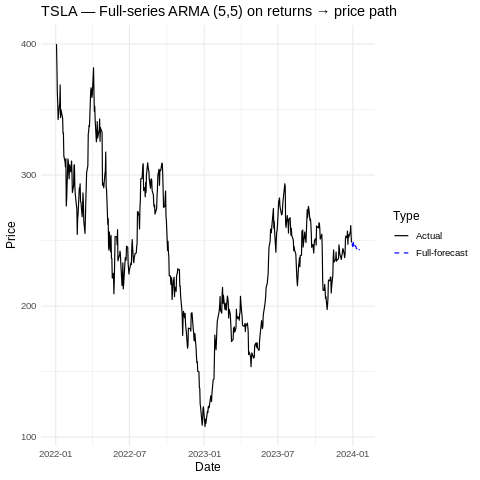

In [20]:
#%%R
sel_full <- select_order_ic(ret, MAX_AR, MAX_MA)
best_full <- sel_full$order
cat("[Full] best (p,q) by AIC:", paste0("(", best_full[1], ",", best_full[2], ")\n"))

print(plot_aic_heatmap(sel_full$aic, paste0(symbol, " Full-series AIC Heatmap (returns)")))

fit_full <- fit_arma_safe(ret, best_full)
ret_pred_full <- if (!is.null(fit_full)) {
  as.numeric(forecast::forecast(fit_full, h = h)$mean)
} else {
  rep(mean(tail(ret, 10)), h)
}

p0 <- tail(px$Close, 1)
px_pred_full <- to_price_path(p0, ret_pred_full)

# ✅ seq()는 length.out 이 맞습니다.
future_dates <- seq(from = px$Date[nrow(px)] + 1, by = "day", length.out = h)

df_plot <- tibble::tibble(
  Date  = c(px$Date, future_dates),
  Price = c(px$Close, px_pred_full),
  Type  = c(rep("Actual", nrow(px)), rep("Full-forecast", length(px_pred_full)))
)

ggplot(df_plot, aes(Date, Price, color = Type, linetype = Type)) +
  geom_line() +
  scale_color_manual(values = c("Actual" = "black", "Full-forecast" = "blue")) +
  scale_linetype_manual(values = c("Actual" = "solid", "Full-forecast" = "dashed")) +
  labs(
    title = paste(
      symbol, "— Full-series ARMA",
      paste0("(", best_full[1], ",", best_full[2], ")"),
      "on returns → price path"
    ),
    x = "Date", y = "Price"
  )


# 6) B) Fixed-origin(정적 파라미터) — (p,q) 자동선택

[Fixed-origin] best (p,q) by AIC: (5,5)
[Fixed-origin static on returns] RMSE=3.0000 | MAE=2.2216 | R2=-0.0205


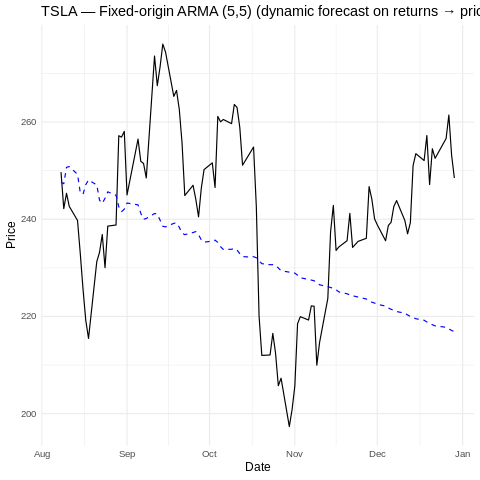

In [21]:
#%%R
sel_fix <- select_order_ic(ret_train, MAX_AR, MAX_MA)
best_fix <- sel_fix$order
cat("[Fixed-origin] best (p,q) by AIC:", paste0("(", best_fix[1], ",", best_fix[2], ")\n"))

print(plot_aic_heatmap(sel_fix$aic, paste0(symbol, " Fixed-origin AIC Heatmap (returns train)")))

fit_static <- fit_arma_safe(ret_train, best_fix)

# ✅ if/else는 같은 블록으로 (중괄호 사용)
ret_pred_static <- if (!is.null(fit_static)) {
  as.numeric(forecast::forecast(fit_static, h = length(ret_test))$mean)
} else {
  rep(mean(tail(ret_train, 10)), length(ret_test))
}

rmse_b <- rmse(ret_test, ret_pred_static)
mae_b  <- mae(ret_test, ret_pred_static)
r2_b   <- r2(ret_test, ret_pred_static)
cat(sprintf("[Fixed-origin static on returns] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_b, mae_b, r2_b))

p0_test <- tail(px_train$Close, 1)
px_pred_static <- to_price_path(p0_test, ret_pred_static)

df_fx <- tibble::tibble(
  Date   = dates_test,
  Actual = px_test$Close,
  Pred   = px_pred_static
)

ggplot(df_fx, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred), color = "blue", linetype = "dashed") +
  labs(
    title = paste(
      symbol, "— Fixed-origin ARMA",
      paste0("(", best_fix[1], ",", best_fix[2], ")"),
      "(dynamic forecast on returns → price)"
    ),
    x = "Date", y = "Price"
  )


# 7) C) Rolling window — (p,q) + (W 후보) 주기적 재선택 + AIC 갭 조건부 재선택

[Rolling-init] W=60, order=(0,0), best AIC=305.02
[Rolling window on returns] RMSE=3.0683 | MAE=2.3434 | R2=-0.0675


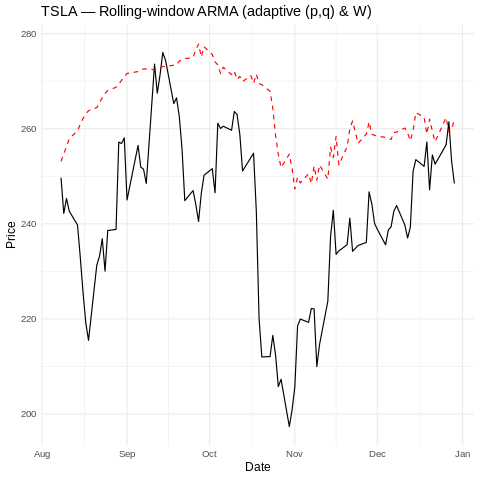

In [22]:
#%%R
initial_select_rolling <- function(hist) {
  best_aic <- Inf
  best_W <- min(W_CANDIDATES[1], length(hist))
  best_order <- c(1L, 1L)
  for (Wc in W_CANDIDATES) {
    y_win <- if (length(hist) >= Wc) tail(hist, Wc) else hist
    sel <- select_order_ic(y_win, MAX_AR, MAX_MA)
    aic_val <- best_aic_value(sel$aic)
    if (is.finite(aic_val) && aic_val < best_aic) {
      best_aic <- aic_val
      best_W <- min(Wc, length(hist))
      best_order <- sel$order
    }
  }
  list(W = best_W, order = best_order, best_aic = best_aic)
}

ret_pred_roll <- rep(NA_real_, length(ret_test))
hist <- ret_train

ini <- initial_select_rolling(hist)
current_W <- ini$W
current_order <- ini$order
current_best_aic <- ini$best_aic
cat(sprintf("[Rolling-init] W=%d, order=(%d,%d), best AIC=%.2f\n", current_W, current_order[1], current_order[2], current_best_aic))

for (i in seq_along(ret_test)) {
  y_win <- if (length(hist) >= current_W) tail(hist, current_W) else hist

  # (1) 주기적 재선택 (W + (p,q))
  if (((i - 1) %% reselect_stride) == 0 || any(is.na(current_order))) {
    ini <- initial_select_rolling(hist)
    current_W <- ini$W
    current_order <- ini$order
    current_best_aic <- ini$best_aic
  }

  # (2) 조건부 재선택: 같은 창에서 현재 order AIC가 최적보다 AIC_GAP 나쁘면 즉시 변경
  aic_now <- evaluate_aic(y_win, current_order)
  sel_w <- select_order_ic(y_win, MAX_AR, MAX_MA)
  best_aic_w <- best_aic_value(sel_w$aic)
  if ((aic_now - best_aic_w) > AIC_GAP) {
    current_order <- sel_w$order
    current_best_aic <- best_aic_w
  }

  # 1-step 예측
  ret_pred_roll[i] <- one_step_forecast(y_win, current_order, min_obs = 40L, fallback_k = 10L)

  # 워크-포워드
  hist <- c(hist, ret_test[i])
}

rmse_c <- rmse(ret_test, ret_pred_roll)
mae_c  <- mae(ret_test, ret_pred_roll)
r2_c   <- r2(ret_test, ret_pred_roll)
cat(sprintf("[Rolling window on returns] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_c, mae_c, r2_c))

px_pred_roll <- to_price_path(tail(px_train$Close, 1), ret_pred_roll)

df_roll <- tibble::tibble(Date = dates_test,
                          Actual = px_test$Close,
                          Pred   = px_pred_roll)

ggplot(df_roll, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred), color = "red", linetype = "dashed") +
  labs(title = paste(symbol, "— Rolling-window ARMA (adaptive (p,q) & W)"),
       x = "Date", y = "Price")


# 8) D) Expanding window — (p,q) 주기적 재선택 + AIC 갭 조건부 재선택

[Expanding window on returns] RMSE=3.1085 | MAE=2.3932 | R2=-0.0957


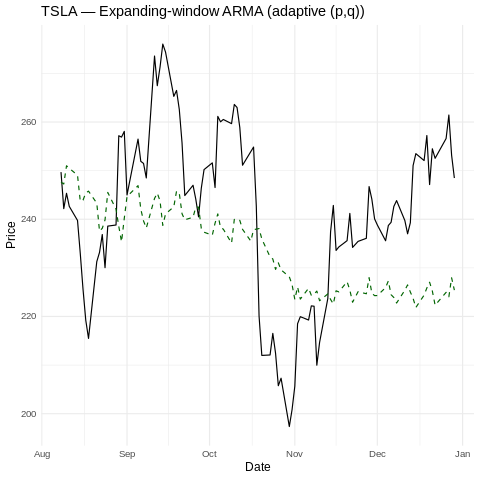

In [23]:
#%%R
ret_pred_exp <- rep(NA_real_, length(ret_test))
hist <- ret_train
current_order <- NULL
current_best_aic <- Inf

for (i in seq_along(ret_test)) {
  # (1) 주기적 재선택
  if (is.null(current_order) || ((i - 1) %% reselect_stride) == 0) {
    sel <- select_order_ic(hist, MAX_AR, MAX_MA)
    current_order <- sel$order
    current_best_aic <- best_aic_value(sel$aic)
  }
  # (2) 조건부 재선택
  aic_now <- evaluate_aic(hist, current_order)
  sel_h <- select_order_ic(hist, MAX_AR, MAX_MA)
  best_aic_h <- best_aic_value(sel_h$aic)
  if ((aic_now - best_aic_h) > AIC_GAP) {
    current_order <- sel_h$order
    current_best_aic <- best_aic_h
  }

  # 1-step 예측
  ret_pred_exp[i] <- one_step_forecast(hist, current_order, min_obs = 40L, fallback_k = 10L)

  # 워크-포워드
  hist <- c(hist, ret_test[i])
}

rmse_d <- rmse(ret_test, ret_pred_exp)
mae_d  <- mae(ret_test, ret_pred_exp)
r2_d   <- r2(ret_test, ret_pred_exp)
cat(sprintf("[Expanding window on returns] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_d, mae_d, r2_d))

px_pred_exp <- to_price_path(tail(px_train$Close, 1), ret_pred_exp)

df_exp <- tibble::tibble(Date = dates_test,
                         Actual = px_test$Close,
                         Pred   = px_pred_exp)

ggplot(df_exp, aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred), color = "darkgreen", linetype = "dashed") +
  labs(title = paste(symbol, "— Expanding-window ARMA (adaptive (p,q))"),
       x = "Date", y = "Price")


# 9) 요약(수익률 기준 지표) & 가격 오버레이

# A tibble: 3 × 4
  Method                            RMSE_ret MAE_ret  R2_ret
  <chr>                                <dbl>   <dbl>   <dbl>
1 Fixed-origin ARMA(5,5)                3.00    2.22 -0.0205
2 Rolling ARMA (adaptive (p,q) & W)     3.07    2.34 -0.0675
3 Expanding ARMA (adaptive (p,q))       3.11    2.39 -0.0957


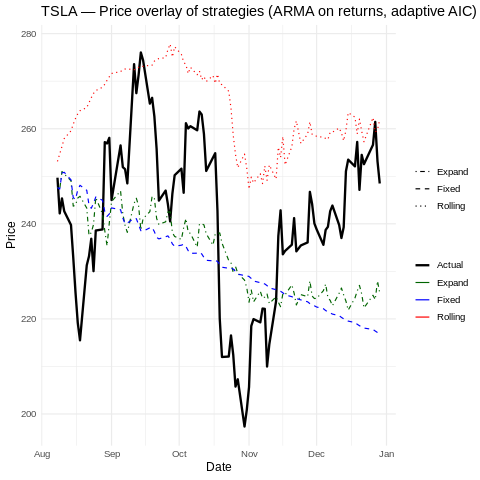

In [24]:
#%%R
summary_tbl <- tibble::tibble(
  Method   = c(
    paste0("Fixed-origin ARMA(", paste(best_fix, collapse=","), ")"),
    "Rolling ARMA (adaptive (p,q) & W)",
    "Expanding ARMA (adaptive (p,q))"
  ),
  RMSE_ret = c(rmse_b, rmse_c, rmse_d),
  MAE_ret  = c(mae_b,  mae_c,  mae_d),
  R2_ret   = c(r2_b,   r2_c,   r2_d)
)

print(dplyr::arrange(summary_tbl, RMSE_ret))

overlay_df <- tibble::tibble(
  Date   = dates_test,
  Actual = px_test$Close,
  Fixed  = to_price_path(tail(px_train$Close, 1), ret_pred_static),
  Rolling= to_price_path(tail(px_train$Close, 1), ret_pred_roll),
  Expand = to_price_path(tail(px_train$Close, 1), ret_pred_exp)
) %>% tidyr::pivot_longer(cols = c("Fixed","Rolling","Expand"),
                          names_to = "Method", values_to = "Pred")

ggplot(overlay_df, aes(Date)) +
  geom_line(aes(y = Actual, color = "Actual"), linewidth = 1.1) +
  geom_line(aes(y = Pred, color = Method, linetype = Method)) +
  scale_color_manual(values = c("Actual"="black","Fixed"="blue","Rolling"="red","Expand"="darkgreen")) +
  scale_linetype_manual(values = c("Fixed"="dashed","Rolling"="dotted","Expand"="dotdash")) +
  labs(title = paste(symbol, "— Price overlay of strategies (ARMA on returns, adaptive AIC)"),
       x = "Date", y = "Price", color = "", linetype = "")
